# Exploration

## Roadmap

My plan is:
* Visualize the features distribution 
    * Search for: Outliers
    * Search for: Possible high correlations
    * Search for: Anything that might pop-up
* See if there's any missing data
    * Imputation
* Look at correlations

[Detailed exploratory data analysis with python](https://www.kaggle.com/ekami66/detailed-exploratory-data-analysis-with-python)

![image.png](http://www.sharpsightlabs.com/wp-content/uploads/2016/05/1_data-analysis-for-ML_how-we-use-dataAnalysis_2016-05-16.png)


## Notes

The first part in all my courses through my bachelors and masters, I learned that the best way to approach a new dataset is by visualizing it.

The next best thing is to inquire the expertises on the area, but I think it will be difficult with this dataset.

On a note, I got the dataset [from here](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009) and the reference link is [here](https://archive.ics.uci.edu/ml/datasets/wine+quality).

The data is related the time periods of May/2004 to February/2007 

The data is related to red wine only.

The features are:
* Input
    1. fixed acidity   
    2. volatile acidity
    3. citric acid
    4. residual sugar
    5. chlorides
    6. free sulfur dioxide
    7. total sulfur dioxide
    8. density
    9. pH
    10. sulphates 
    11. alcohol   
* Output variable (based on sensory data):
    12. quality (score between 0 and 10)
    
    

## Todo



In [2]:
# Import libraries

import pandas as pd
import numpy as np

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import IsolationForest
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

# Import data

## Create Spark Session

In [5]:
spark = (SparkSession
        .builder
        .appName("Red Wine")
        .getOrCreate())

21/11/08 17:47:43 WARN Utils: Your hostname, OutOne resolves to a loopback address: 127.0.1.1; using 10.101.136.114 instead (on interface wlp8s0)
21/11/08 17:47:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/11/08 17:47:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Get DVC url for the data

In [6]:
dfInput = pd.read_csv('../input/winequality-red.csv')

dfInputS = (spark
            .read.format("csv")
            .option("header",True)
            .load("../input/winequality-red.csv"))

# https://stackoverflow.com/questions/53105033/how-do-i-create-a-seaborn-line-plot-for-pyspark-dataframe

In [4]:
dfInput.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [5]:
dfInputS.head()

Row(fixed acidity='7.4', volatile acidity='0.7', citric acid='0.0', residual sugar='1.9', chlorides='0.076', free sulfur dioxide='11.0', total sulfur dioxide='34.0', density='0.9978', pH='3.51', sulphates='0.56', alcohol='9.4', quality='5')

First impressions, everything but $free sulfur dioxide$, $total sulfur dioxide$ and $quality$ are features that can take any float value.

In [6]:
dfInput.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


And have 1599 observations. Only $quality$ is described as being an integer.   
And from this piece of code, there are no empty/missing values.  
That is perfect.

# Visualization


dfInputS.select(col('quality'))## Distribution: Target - Quality

<AxesSubplot:xlabel='quality', ylabel='Density'>

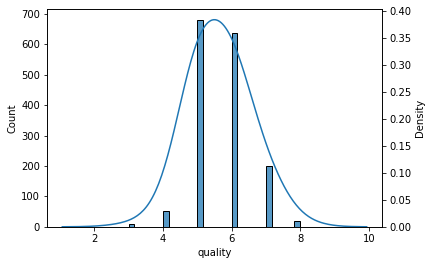

In [7]:
## https://seaborn.pydata.org/generated/seaborn.kdeplot.html
## https://seaborn.pydata.org/generated/seaborn.histplot.html
## Adapted from: 
## https://stackoverflow.com/a/48991009
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.histplot(dfInput['quality'], ax=ax1)
sns.kdeplot(dfInput['quality'], ax=ax2, bw_method=0.8)

In [8]:
dfInput['quality'].describe()

count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

Quality follows a normal distribution, with a mean between 5 and 6. The max quality is of 8.  
Yet, it is skewd to the right. I'll keep an eye out if this is a problem in regression/classification.

<AxesSubplot:xlabel='quality', ylabel='Density'>

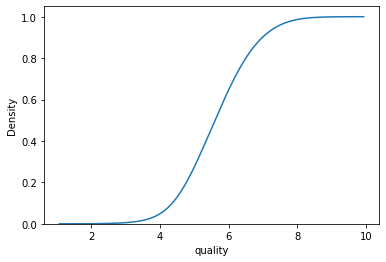

In [9]:
sns.kdeplot(dfInput['quality'], bw_method=0.8, cumulative = True)

## Distribution: Independent features

Since there aren't that many features, I will use the seaborn `pairplot` function and analyse all 11 features at once.

Aid visualizations   
![image.png](https://www.vosesoftware.com/riskwiki/images/M-M0589-A_1.png)   
![image.png](https://i.imgur.com/BdTSZzY.png)


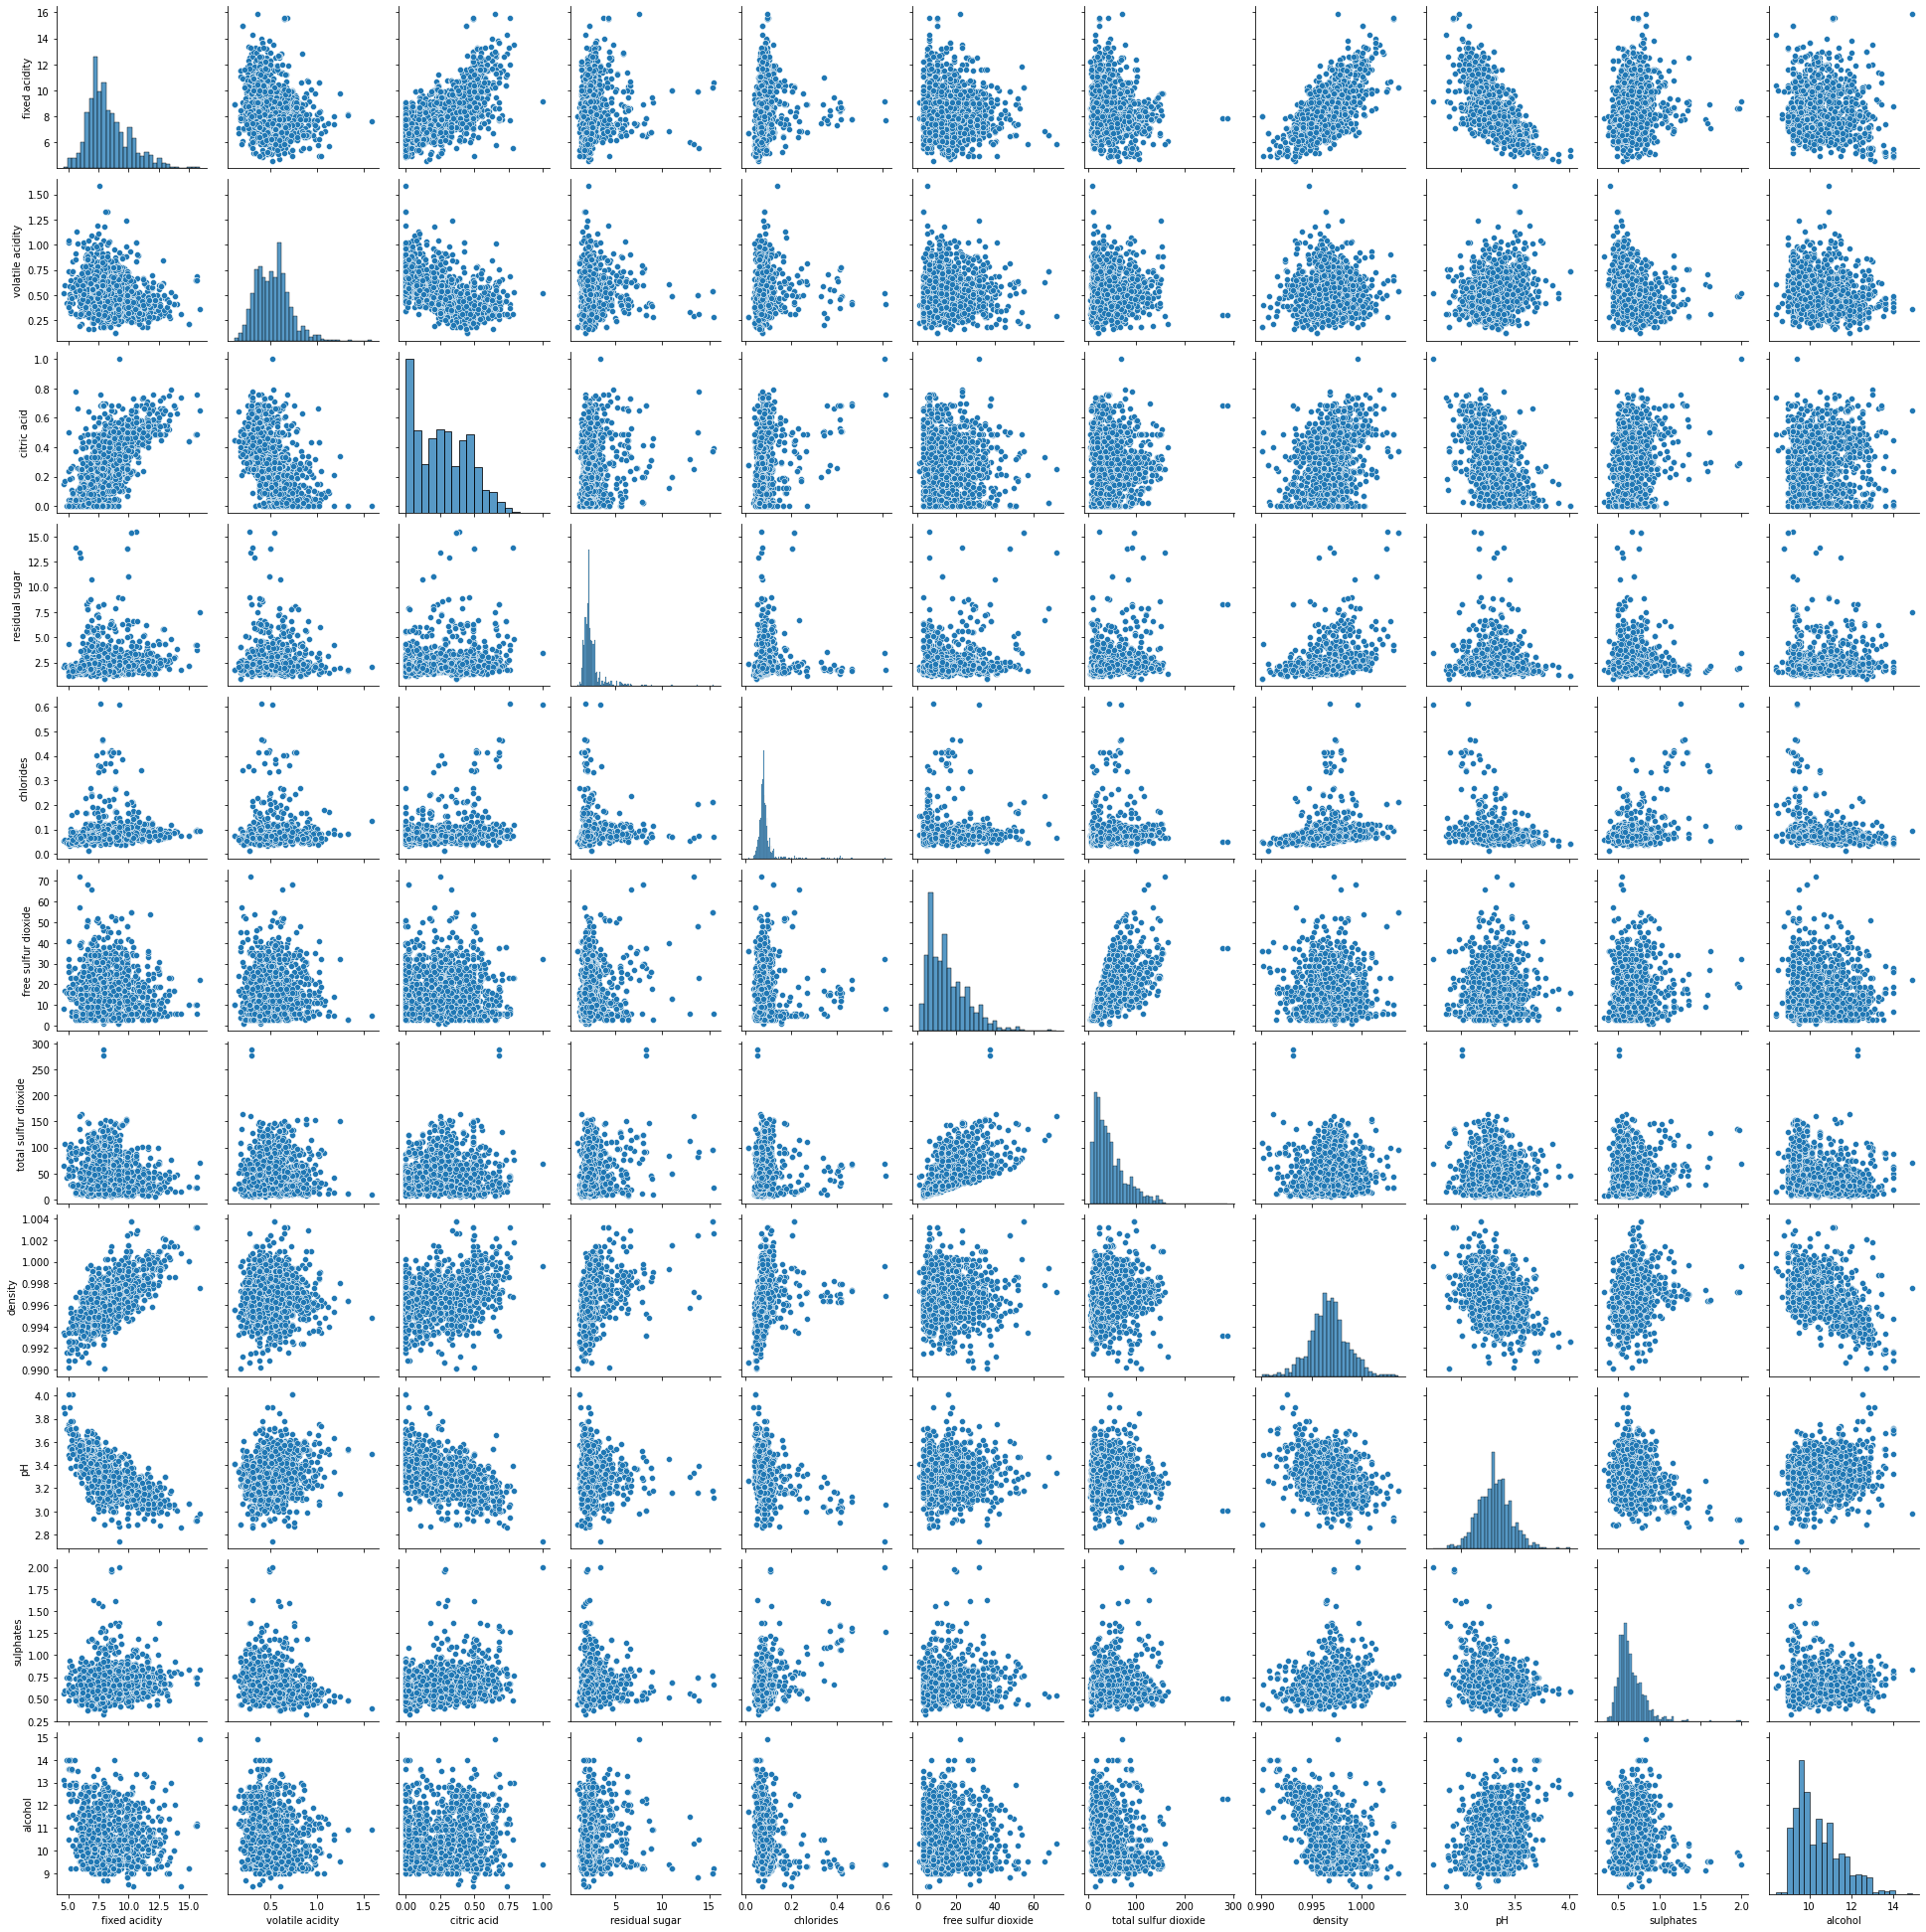

In [10]:
## https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn.pairplot

sns.pairplot(dfInput.loc[:, dfInput.columns != 'quality'])

Lets start with `fixed acidity`.
1. It presents a somewhat normal distribution to the left. Maybe it's a Gamma? I will test it in the next section.
2. It appears to have a linear correlation with `density` the most. And an inverse linear correlation with `pH`.

Looking at the `voletile acidity`,
1. It appears to follow a normal distribution.
2. Doesn't appear to have any linear correlation with the other features. I will check in a future section if this is actual the case.

Looking at `citric acid`:
1. Doesn't have an apparent distribution, but I will do a goodness-of-fit test for Gamma, Normal and Burr

Looking at `residual sugar`:
1. This feature is highly concentrated in the first few values (between 0 and 2?).
2. It hardly shows any good correlation with other features.
3. It appears to have a few outliers. 

Looking at `chlorides`:
1. This feature is highly concentrated between 0.1 and 0.2. Can use exponential on this one, and check the results?
2. Without values >0.3, this might be a normal distribution.

Looking at `free sulfur dioxide`:
1. It appears to have a lognormal or Gamma distribution.
2. It shows a somewhat linear correlation with `total sulfur dioxide`. The names of these features point for them coming from the same domain. I will keep an eye out and test the linearity between these two.

Looking at `total sulfur dioxide`:
1. It has some outliers candidates in the range >200

Looking at `density` and `pH`:
1. Both seem to have a normal distribution and no outlier candidates.

Looking at `sulphates`:
1. Appears to have a Log Normal distribution.
2. Some outlier candidates in the values >1.5

<AxesSubplot:>

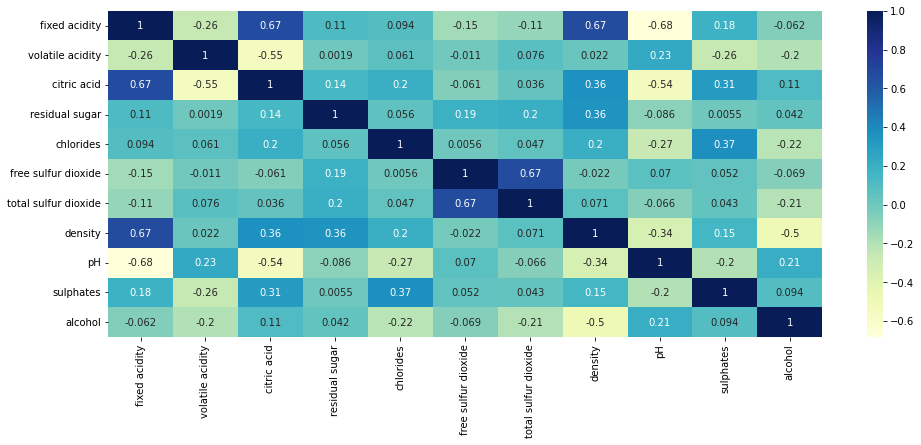

In [11]:
plt.figure(figsize=(16, 6))
sns.heatmap(dfInput.loc[:, dfInput.columns != 'quality'].corr(), cmap="YlGnBu", annot=True)

* `Fixed acidity` with `Citric Acid`, `Density` & `pH`.   
* `Citric Acid` with `pH`.    
* `Free Sulfur Dioxide` with `Total Sulfur Dioxide`.   

## Actions on observed behaviour

### Is `fixed acidity` gamma or normal distributed?

Kolmogorov-Smirnov Goodness-of-fit Test:
                 Gamma:
                     	 Statistic 0.05877180396535564	 P-value: 3.0453111968749534e-05 
                 Normal:
                     	 Statistic 0.11050460798947254	 P-value: 1.8409932346877605e-17
Cramér-von Mises Goodness-of-fit Test:
                 Gamma:
                     	 Statistic 1.0707617689520559	 P-value: 0.0016772546305987568 
                 Normal:
                     	 Statistic 5.0433960822972566	 P-value: 5.6895932409872785e-11


<AxesSubplot:xlabel='Normal', ylabel='Density'>

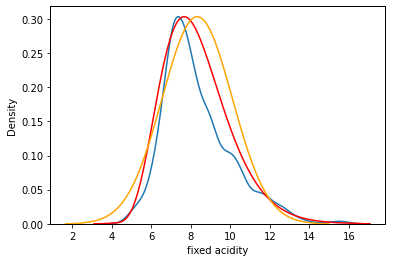

In [12]:
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cramervonmises.html
## https://stackoverflow.com/a/2896284
## https://stackoverflow.com/a/40599521

fa_alpha, fa_loc, fa_scale = stats.gamma.fit(dfInput['fixed acidity'])
ks_gamma_test = stats.kstest(dfInput['fixed acidity'], 'gamma', args=(fa_alpha, fa_loc, fa_scale))
fa_mean, fa_var = stats.norm.fit(dfInput['fixed acidity'])
ks_normal_test = stats.kstest(dfInput['fixed acidity'], 'norm', args=(fa_mean, fa_var))

cvm_gamma_test = stats.cramervonmises(dfInput['fixed acidity'], 'gamma', args=(fa_alpha, fa_loc, fa_scale))
cvm_normal_test = stats.cramervonmises(dfInput['fixed acidity'], 'norm', args=(fa_mean, fa_var))
print(f'Kolmogorov-Smirnov Goodness-of-fit Test:\n \
                Gamma:\n \
                    \t Statistic {ks_gamma_test[0]}\t P-value: {ks_gamma_test[1]} \n \
                Normal:\n \
                    \t Statistic {ks_normal_test[0]}\t P-value: {ks_normal_test[1]}')

print(f'Cramér-von Mises Goodness-of-fit Test:\n \
                Gamma:\n \
                    \t Statistic {cvm_gamma_test.statistic}\t P-value: {cvm_gamma_test.pvalue} \n \
                Normal:\n \
                    \t Statistic {cvm_normal_test.statistic}\t P-value: {cvm_normal_test.pvalue}')



## Verify the sample distribution vs gamma estimated parameters vs normal parameters
dfFAsorted = pd.DataFrame({'fixed acidity': dfInput['fixed acidity'].sort_values()})
dfFAsorted['Gamma'] = stats.gamma.ppf(np.arange(0, 1, 1/len(dfFAsorted)), a = fa_alpha, loc = fa_loc, scale = fa_scale)
dfFAsorted['Normal'] = stats.norm.ppf(np.arange(0, 1, 1/len(dfFAsorted)), loc = fa_mean, scale = fa_var)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_yticks([])
ax3 = ax1.twinx()
ax3.set_yticks([])

sns.kdeplot(dfFAsorted['fixed acidity'], ax=ax1, bw_method=0.2)
sns.kdeplot(dfFAsorted['Gamma'], ax=ax2, bw_method=0.2, color='red')
sns.kdeplot(dfFAsorted['Normal'], ax=ax3, bw_method=0.2, color='orange')

Legend:
* Blue: Sample distribution
* Red: Gamma Distribution with estimated parameters
* Yellow: Normal distribution with estimated parameters

Normal has a better goodness-of-fit test, even though the p-value of both is very low, and through the plot, Gamma seems to fit better the data in hands.

The p-value relies on the approximation given by equation 1.8 in . It is important to keep in mind that the p-value is only accurate if one tests a simple hypothesis, i.e. the parameters of the reference distribution are known. If the parameters are estimated from the data (composite hypothesis), the computed p-value is not reliable. - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cramervonmises.html

### What's `citric acid` best describing distribution?

Kolmogorov-Smirnov Goodness-of-fit Test:
                 Gamma:
                     	 Statistic 0.23211105847280317	 P-value: 3.1224157406103614e-76 
                 Normal:
                     	 Statistic 0.08394056522867449	 P-value: 2.9965986409438043e-10 
                 Burr:
                     	 Statistic 0.1686722215033119	 P-value: 3.0885498906646853e-40
Cramér-von Mises Goodness-of-fit Test:
                 Gamma:
                     	 Statistic 27.473076158418205	 P-value: 1.3290700540125044e-08 
                 Normal:
                     	 Statistic 2.2559722663120154	 P-value: 3.3718661446302534e-06 
                 Burr:
                     	 Statistic 15.34775957717461	 P-value: 2.8425662934594698e-09


<AxesSubplot:xlabel='Burr', ylabel='Density'>

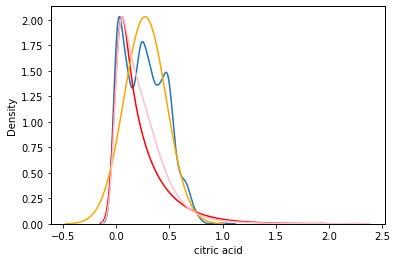

In [13]:
dfFAsorted = pd.DataFrame({'citric acid': dfInput['citric acid'].sort_values()})

fa_alpha, fa_loc, fa_scale = stats.gamma.fit(dfInput['citric acid'])
ks_gamma_test = stats.kstest(dfInput['citric acid'], 'gamma', args=(fa_alpha, fa_loc, fa_scale))
cvm_gamma_test = stats.cramervonmises(dfInput['citric acid'], 'gamma', args=(fa_alpha, fa_loc, fa_scale))
dfFAsorted['Gamma'] = stats.gamma.ppf(np.arange(0, 1, 1/len(dfFAsorted)), 
                                      a = fa_alpha, loc = fa_loc, scale = fa_scale)

fa_mean, fa_var = stats.norm.fit(dfInput['citric acid'])
ks_normal_test = stats.kstest(dfInput['citric acid'], 'norm', args=(fa_mean, fa_var))
cvm_normal_test = stats.cramervonmises(dfInput['citric acid'], 'norm', args=(fa_mean, fa_var))
dfFAsorted['Normal'] = stats.norm.ppf(np.arange(0, 1, 1/len(dfFAsorted)), 
                                      loc = fa_mean, scale = fa_var)

fa_c, fa_d, fa_loc, fa_scale = stats.burr.fit(dfInput['citric acid'])
ks_burr_test = stats.kstest(dfInput['citric acid'], 'burr', args=(fa_c, fa_d, fa_loc, fa_scale))
cvm_burr_test = stats.cramervonmises(dfInput['citric acid'], 'burr', args=(fa_c, fa_d, fa_loc, fa_scale))
dfFAsorted['Burr'] = stats.burr.ppf(np.arange(0, 1, 1/len(dfFAsorted)), 
                                    c = fa_c, d = fa_d, loc = fa_loc, scale = fa_scale)

print(f'Kolmogorov-Smirnov Goodness-of-fit Test:\n \
                Gamma:\n \
                    \t Statistic {ks_gamma_test[0]}\t P-value: {ks_gamma_test[1]} \n \
                Normal:\n \
                    \t Statistic {ks_normal_test[0]}\t P-value: {ks_normal_test[1]} \n \
                Burr:\n \
                    \t Statistic {ks_burr_test[0]}\t P-value: {ks_burr_test[1]}')

print(f'Cramér-von Mises Goodness-of-fit Test:\n \
                Gamma:\n \
                    \t Statistic {cvm_gamma_test.statistic}\t P-value: {cvm_gamma_test.pvalue} \n \
                Normal:\n \
                    \t Statistic {cvm_normal_test.statistic}\t P-value: {cvm_normal_test.pvalue} \n \
                Burr:\n \
                    \t Statistic {cvm_burr_test.statistic}\t P-value: {cvm_burr_test.pvalue}')



## Verify the sample distribution vs gamma estimated parameters vs normal parameters
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_yticks([])
ax3 = ax1.twinx()
ax3.set_yticks([])
ax4 = ax1.twinx()
ax4.set_yticks([])

sns.kdeplot(dfFAsorted['citric acid'], ax=ax1, bw_method=0.2)
sns.kdeplot(dfFAsorted['Gamma'], ax=ax2, bw_method=0.2, color='red')
sns.kdeplot(dfFAsorted['Normal'], ax=ax3, bw_method=0.2, color='orange')
sns.kdeplot(dfFAsorted['Burr'], ax=ax4, bw_method=0.2, color='pink')

The p-value relies on the approximation given by equation 1.8 in . It is important to keep in mind that the p-value is only accurate if one tests a simple hypothesis, i.e. the parameters of the reference distribution are known. If the parameters are estimated from the data (composite hypothesis), the computed p-value is not reliable. - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cramervonmises.html  

Normal seems to be better fitting, but it's not ideal.

### Outliers on `residual sugar`

https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561

https://www.analyticsvidhya.com/blog/2021/07/anomaly-detection-using-isolation-forest-a-complete-guide/

In [14]:
random_state = np.random.RandomState(42)

In [15]:
rs_outliers=IsolationForest(n_estimators=100,
                            contamination=float(0.015),
                            random_state=random_state,
                            max_samples = 64)

rs_outliers.fit(dfInput[['residual sugar']])

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
print(rs_outliers.get_params())

{'bootstrap': False, 'contamination': 0.015, 'max_features': 1.0, 'max_samples': 64, 'n_estimators': 100, 'n_jobs': None, 'random_state': RandomState(MT19937) at 0x7F8554334340, 'verbose': 0, 'warm_start': False}


In [16]:
dfRSOutlier = pd.DataFrame(dfInput['residual sugar'])
dfRSOutlier['score'] = rs_outliers.decision_function(dfInput[['residual sugar']])
dfRSOutlier['anomaly_score'] = rs_outliers.predict(dfInput[['residual sugar']])

<AxesSubplot:xlabel='residual sugar', ylabel='score'>

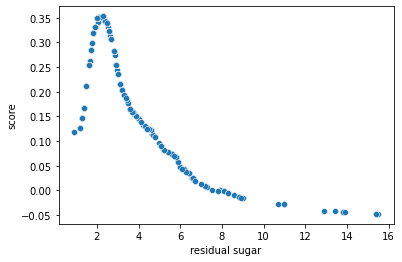

In [17]:
sns.scatterplot(x = dfRSOutlier['residual sugar'], y = dfRSOutlier['score'])

<AxesSubplot:xlabel='residual sugar', ylabel='anomaly_score'>

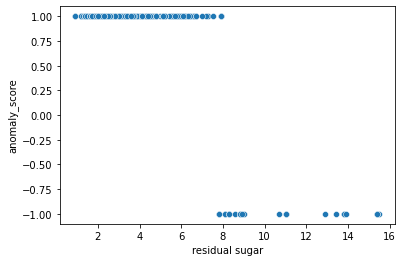

In [18]:
sns.scatterplot(x = dfRSOutlier['residual sugar'], y = dfRSOutlier['anomaly_score'])

I want to apply other methods, but I'll wait for other features having outliers, and round them all up with another method.

### Chlorides feature


<AxesSubplot:xlabel='chlorides', ylabel='Count'>

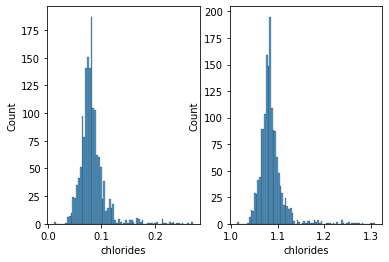

In [19]:
fig, ax =plt.subplots(1,2)
dfFilterChlorides = (dfInput['chlorides'] < 0.3)
sns.histplot((dfInput.loc[dfFilterChlorides,'chlorides']), ax = ax[0])
sns.histplot(np.exp(dfInput.loc[dfFilterChlorides,'chlorides']), ax = ax[1])

High amount of observations between 0.05 e 0.12

### The `free sulfur dioxide` distribution and linearity with `total sulfur dioxide`

Kolmogorov-Smirnov Goodness-of-fit Test:
                 Gamma:
                     	 Statistic 0.06856144050176188	 P-value: 5.5793699517557e-07 
                 LogNormal:
                     	 Statistic 0.07713770726737582	 P-value: 1.0109581906907079e-08
Cramér-von Mises Goodness-of-fit Test:
                 Gamma:
                     	 Statistic 0.7171766952906672	 P-value: 0.011563273775919591 
                 LogNormal:
                     	 Statistic 1.1443833831025154	 P-value: 0.0011304158680263132


<AxesSubplot:xlabel='Log Normal', ylabel='Density'>

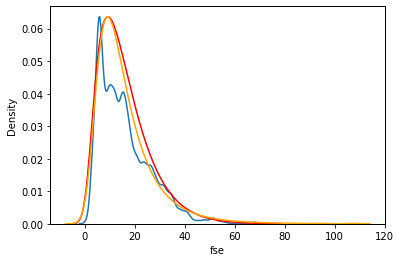

In [20]:
dfFAsorted = pd.DataFrame({'fse': dfInput['free sulfur dioxide'].sort_values()})

fa_alpha, fa_loc, fa_scale = stats.gamma.fit(dfInput['free sulfur dioxide'])
ks_gamma_test = stats.kstest(dfInput['free sulfur dioxide'], 'gamma', args=(fa_alpha, fa_loc, fa_scale))
cvm_gamma_test = stats.cramervonmises(dfInput['free sulfur dioxide'], 'gamma', args=(fa_alpha, fa_loc, fa_scale))
dfFAsorted['Gamma'] = stats.gamma.ppf(np.arange(0, 1, 1/len(dfFAsorted)), 
                                      a = fa_alpha, loc = fa_loc, scale = fa_scale)

fa_s, fa_loc, fa_scale = stats.lognorm.fit(dfInput['free sulfur dioxide'])
ks_normal_test = stats.kstest(dfInput['free sulfur dioxide'], 'lognorm', args=(fa_s, fa_loc, fa_scale))
cvm_normal_test = stats.cramervonmises(dfInput['free sulfur dioxide'], 'lognorm', args=(fa_s, fa_loc, fa_scale))
dfFAsorted['Log Normal'] = stats.lognorm.ppf(np.arange(0, 1, 1/len(dfFAsorted)), 
                                      s  = fa_s, loc = fa_loc, scale = fa_scale)


print(f'Kolmogorov-Smirnov Goodness-of-fit Test:\n \
                Gamma:\n \
                    \t Statistic {ks_gamma_test[0]}\t P-value: {ks_gamma_test[1]} \n \
                LogNormal:\n \
                    \t Statistic {ks_normal_test[0]}\t P-value: {ks_normal_test[1]}')

print(f'Cramér-von Mises Goodness-of-fit Test:\n \
                Gamma:\n \
                    \t Statistic {cvm_gamma_test.statistic}\t P-value: {cvm_gamma_test.pvalue} \n \
                LogNormal:\n \
                    \t Statistic {cvm_normal_test.statistic}\t P-value: {cvm_normal_test.pvalue}')



## Verify the sample distribution vs gamma estimated parameters vs normal parameters
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_yticks([])
ax3 = ax1.twinx()
ax3.set_yticks([])

sns.kdeplot(dfFAsorted['fse'], ax=ax1, bw_method=0.1)
sns.kdeplot(dfFAsorted['Gamma'], ax=ax2, bw_method=0.2, color='red')
sns.kdeplot(dfFAsorted['Log Normal'], ax=ax3, bw_method=0.2, color='orange')

Log Normal seems to fit better, but even that is not good enough.

Now lets look at the linearity between this feature and `total sulful dioxide`


In [21]:
fsd_tsd_pearson = stats.pearsonr(dfInput['free sulfur dioxide'], dfInput['total sulfur dioxide'])

In [22]:
print(f'Correlation is {fsd_tsd_pearson[0]}, which is very high.')

Correlation is 0.6676664504810215, which is very high.


### `total sulfur dioxide` Outliers

{'bootstrap': False, 'contamination': 0.01, 'max_features': 1.0, 'max_samples': 222, 'n_estimators': 1000, 'n_jobs': None, 'random_state': RandomState(MT19937) at 0x7F8554334340, 'verbose': 0, 'warm_start': False}


/home/portugapt/.pyenv/versions/3.8.1/envs/LearnHub/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total sulfur dioxide', ylabel='anomaly_score'>

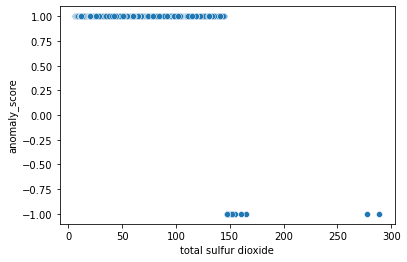

In [23]:
tsd_outliers=IsolationForest(n_estimators=1000,
                            contamination=float(0.01),
                            random_state=random_state,
                            max_samples = 222)

tsd_outliers.fit(dfInput[['total sulfur dioxide']])

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
print(tsd_outliers.get_params())

dfTSDOutlier = pd.DataFrame(dfInput['total sulfur dioxide'])
dfTSDOutlier['score'] = tsd_outliers.decision_function(dfInput[['total sulfur dioxide']])
dfTSDOutlier['anomaly_score'] = tsd_outliers.predict(dfInput[['total sulfur dioxide']])

sns.scatterplot(dfTSDOutlier['total sulfur dioxide'], dfTSDOutlier['anomaly_score'])

Clearly, there are a few values outside the norm.

# Prepare Data

## Remove outlier candidates

I choose these cuts based on the isolation forests and observations that looked too far off from the normal values.

I will however validate these values by:
1. Do Isolation forests with all the features, where the contamination is an estimate based on this method. And look the overlap of observations with the two methods.
2. Check the average quality of the removed observations.
3. Train a model with all the observations anyway, to compare the performance with and without these features.

In [24]:
dfPrepare = dfInput.loc[dfInput['residual sugar'] < 10, ]
dfPrepare = dfPrepare.loc[dfPrepare['chlorides'] < 0.5, ]
dfPrepare = dfPrepare.loc[dfPrepare['total sulfur dioxide'] < 200, ]

In [25]:
dfInput.size - dfPrepare.size 

180

Verify the `quality` of the removed observations

In [26]:
dfDifference = dfInput.loc[dfInput.index.difference(dfPrepare.index), ]

print(f'Input quality mean: {dfInput["quality"].mean()}')
print(f'Prepared data quality mean: {dfPrepare["quality"].mean()}')
print(f'Outlier candidates quality mean: {dfDifference["quality"].mean()}')


Input quality mean: 5.6360225140712945
Prepared data quality mean: 5.636363636363637
Outlier candidates quality mean: 5.6


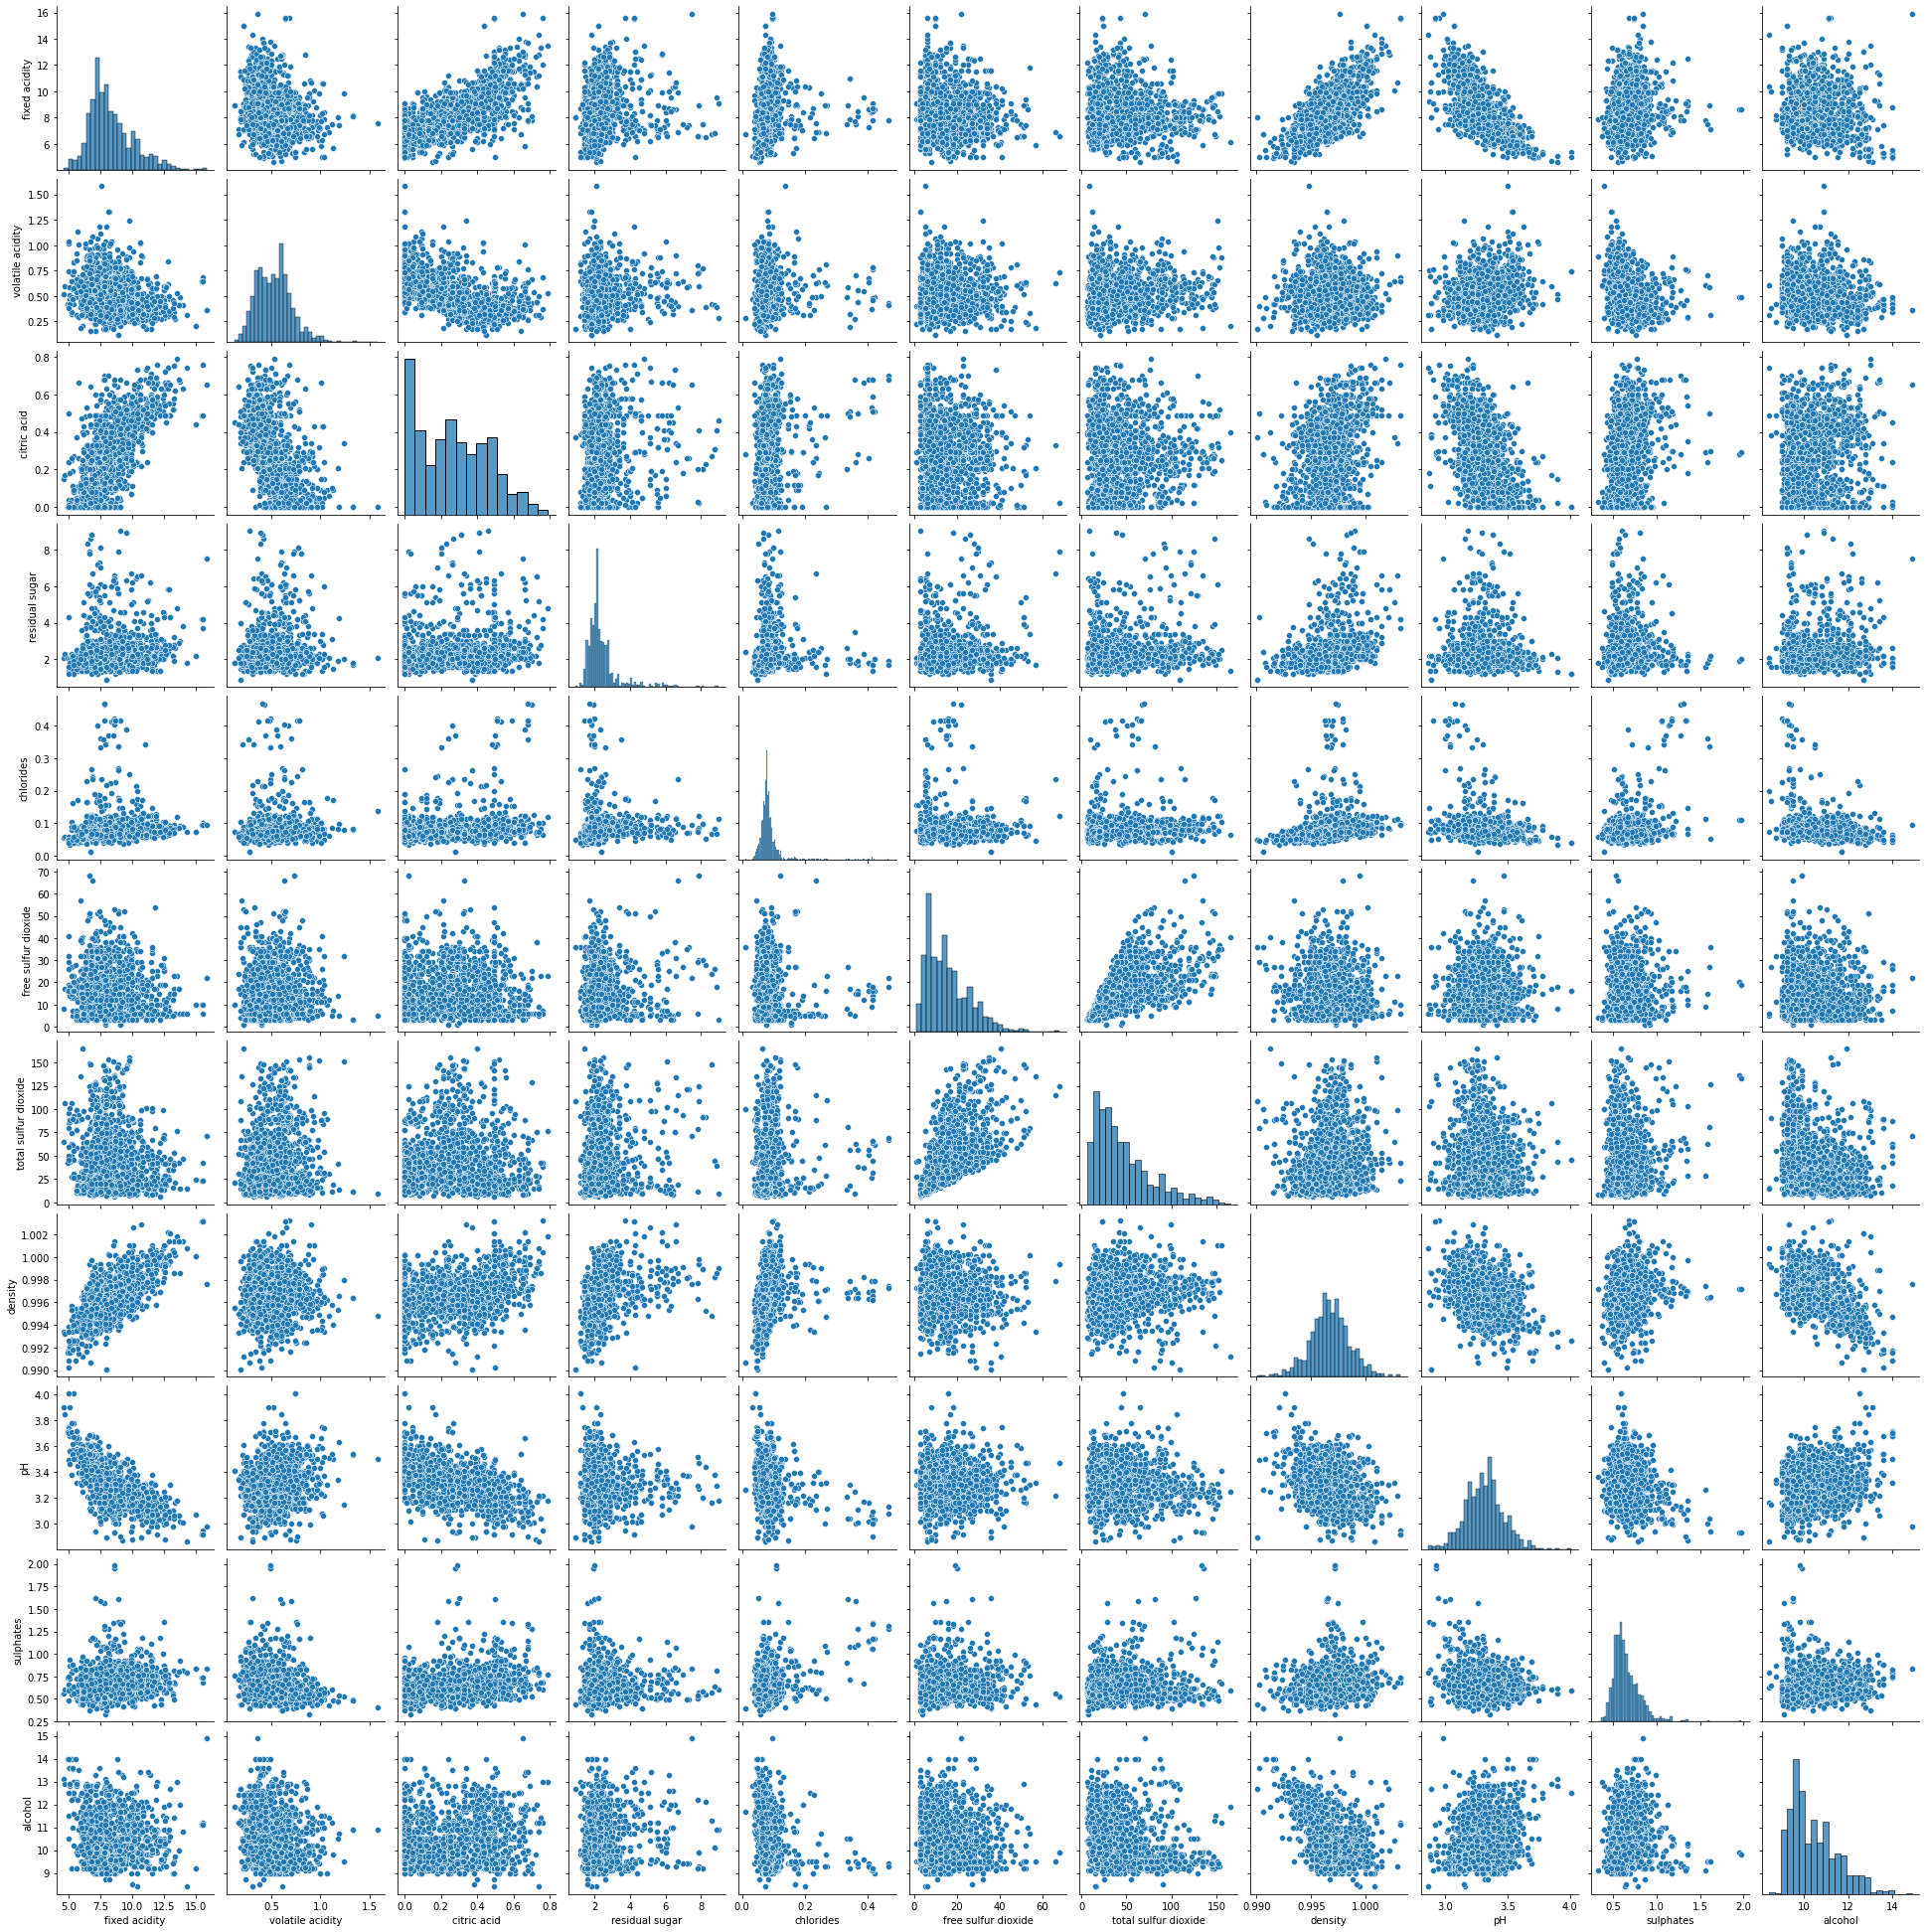

In [27]:
sns.pairplot(dfPrepare.loc[:, dfPrepare.columns != 'quality'])

## Correlation with target & A-B Correlation

In [28]:
for i in dfPrepare.columns[dfPrepare.columns != 'quality']:
    print(f"Correlation with {i}: {stats.pearsonr(dfInput['quality'], dfInput[i])[0]}")

Correlation with fixed acidity: 0.12405164911322429
Correlation with volatile acidity: -0.39055778026400717
Correlation with citric acid: 0.2263725143180414
Correlation with residual sugar: 0.013731637340066292
Correlation with chlorides: -0.12890655993005265
Correlation with free sulfur dioxide: -0.050656057244276395
Correlation with total sulfur dioxide: -0.18510028892653785
Correlation with density: -0.17491922778334873
Correlation with pH: -0.05773139120538215
Correlation with sulphates: 0.25139707906926123
Correlation with alcohol: 0.47616632400113607


1. Highest correlation with alcohol
2. Then volatile acidity
3. After, sulphates.

* Total sulfur dioxide has a higher correlation with the target than free sulfur dioxide. It's better to keep the former.

In [43]:
dfCorrs = dfPrepare.corr()
dfCorrs.to_csv('output/CorrMatrix.csv', index = False)
dfCorrs

fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000         -0.260273     0.683805   
volatile acidity          -0.260273          1.000000    -0.553951   
citric acid                0.683805         -0.553951     1.000000   
residual sugar             0.138320          0.046775     0.138397   
chlorides                  0.094229          0.070449     0.175220   
free sulfur dioxide       -0.161165         -0.004455    -0.078488   
total sulfur dioxide      -0.112640          0.096921     0.011498   
density                    0.673486          0.022865     0.374261   
pH                        -0.687371          0.232856    -0.536033   
sulphates                  0.182252         -0.269907     0.302672   
alcohol                   -0.055501         -0.202563     0.113570   
quality                    0.126077         -0.393286     0.233410   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity               0.138320   0.094229            -0.161165   
volatile acidity            0.046775   0.070449            -0.004455   
citric acid                 0.138397   0.175220            -0.078488   
residual sugar              1.000000   0.022330             0.103993   
chlorides                   0.022330   1.000000            -0.021607   
free sulfur dioxide         0.103993  -0.021607             1.000000   
total sulfur dioxide        0.144401   0.050116             0.671680   
density                     0.344138   0.189532            -0.050618   
pH                         -0.062592  -0.249237             0.086529   
sulphates                   0.010475   0.322785             0.049093   
alcohol                     0.105029  -0.218450            -0.062355   
quality                     0.017115  -0.118700            -0.058468   

                      total sulfur dioxide   density        pH  sulphates  \
fixed acidity                    -0.112640  0.673486 -0.687371   0.182252   
volatile acidity                  0.096921  0.022865  0.232856  -0.269907   
citric acid                       0.011498  0.374261 -0.536033   0.302672   
residual sugar                    0.144401  0.344138 -0.062592   0.010475   
chlorides                         0.050116  0.189532 -0.249237   0.322785   
free sulfur dioxide               0.671680 -0.050618  0.086529   0.049093   
total sulfur dioxide              1.000000  0.082376 -0.048476   0.052681   
density                           0.082376  1.000000 -0.342391   0.140783   
pH                               -0.048476 -0.342391  1.000000  -0.180772   
sulphates                         0.052681  0.140783 -0.180772   1.000000   
alcohol                          -0.228436 -0.487693  0.205159   0.108238   
quality                          -0.208638 -0.174455 -0.061124   0.273595   

                       alcohol   quality  
fixed acidity        -0.055501  0.126077  
volatile acidity     -0.202563 -0.393286  
citric acid           0.113570  0.233410  
residual sugar        0.105029  0.017115  
chlorides            -0.218450 -0.118700  
free sulfur dioxide  -0.062355 -0.058468  
total sulfur dioxide -0.228436 -0.208638  
density              -0.487693 -0.174455  
pH                    0.205159 -0.061124  
sulphates             0.108238  0.273595  
alcohol               1.000000  0.477630  
quality               0.477630  1.000000

In [42]:
dfABCorrs = pd.DataFrame(columns = ['Feature A', 'Feature B', 'Correlation'])
idx = 0
for i in dfCorrs.columns:
    for j in dfCorrs.columns:
        dfABCorrs.loc[idx] = [i, j, dfCorrs.loc[i, j]]
        idx += 1
dfABCorrs.to_csv('output/ABCorr.csv', index = False)

## Save Prepared Data

In [45]:
dfPrepare.to_csv('output/dataPrepared.csv', index_label = 'idx')